## Hands on Practical Deep learning with PyTorch
### Sign Language Digits Dataset
https://www.kaggle.com/ankitjha/hands-on-practical-deep-learning-with-pytorch/notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
data = np.load('./data/X.npy')
target = np.load('./data/Y.npy')
Y = np.zeros(data.shape[0])
Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = .02, random_state = 2) 
## splitting into train and test set

In [4]:
X_train.shape, X_train.max(), X_train.min()

((2020, 64, 64), 1.0, 0.003921569)

-  Data must be wrapped on a Dataset parent class where the methods getitem and len must be overrided. Not that, the data is not loaded on memory by now.
- The Dataloader reads the data and puts it into memory.

- torchvision - It is used to load and prepare dataset. Using it you can create transformations on the input data. 

- transforms - It is used for preprocessing images and performing operations sequentially. 

- num_workers - It is used for multiprocessing.Normally, num_workers = 4 * (number of gpus) works well.

In [5]:
print(X_train.shape)
x = X_train[77:78,...]
print(x.shape)
x = x.reshape((-1, 64, 64)).astype(np.uint8)[:, :, :, None]
print(x.shape)

(2020, 64, 64)
(1, 64, 64)
(1, 64, 64, 1)


In [6]:
from torch.utils.data import Dataset


class DatasetProcessing(Dataset):
    def __init__(self, data, target, transform=None):
        # used to initialise the class variables - transform, data, target
        self.transform = transform
        self.data = data.reshape((-1, 64, 64)).astype(np.uint8)[:, :, :, None]
        self.target = torch.from_numpy(target).long()
        # needs to be in torch.LongTensor dtype

    def __getitem__(self, index):
        # used to retrieve the X and y index value and return it
        return self.transform(self.data[index]), self.target[index]

    def __len__(self):
        # returns the length of the data
        return len(list(self.data))

In [7]:
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])
dset_train = DatasetProcessing(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(
    dset_train, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
xx, yy = next(iter(test_loader))
xx.shape, yy.shape

In [8]:
dset_test = DatasetProcessing(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    dset_test, batch_size=4, shuffle=True, num_workers=0)

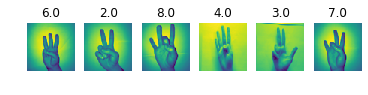

In [9]:
import matplotlib.pyplot as plt
for num, x in enumerate(X_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

In [15]:
from torch import nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    print('Cuda!')
    model = model.cuda()
    criterion = criterion.cuda()

Cuda!


In [23]:
from torch.autograd import Variable
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        #print(data.size())
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        #print(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [26]:
import torch.nn.functional as F
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0

    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).data[0]
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(data_loader.dataset)

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [27]:
n_epochs = 2

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [400/2020 (20%)]	Loss: 2.263616
Train Epoch: 0 [800/2020 (40%)]	Loss: 2.353625
Train Epoch: 0 [1200/2020 (59%)]	Loss: 2.254875
Train Epoch: 0 [1600/2020 (79%)]	Loss: 2.420415
Train Epoch: 0 [2000/2020 (99%)]	Loss: 2.335770

Average loss: 2.3039, Accuracy: 203/2020 (10.050%)

Train Epoch: 1 [400/2020 (20%)]	Loss: 2.361205
Train Epoch: 1 [800/2020 (40%)]	Loss: 2.266119
Train Epoch: 1 [1200/2020 (59%)]	Loss: 2.247723
Train Epoch: 1 [1600/2020 (79%)]	Loss: 2.276873
Train Epoch: 1 [2000/2020 (99%)]	Loss: 2.327617

Average loss: 2.3052, Accuracy: 202/2020 (10.000%)

